# `TidalCNN` part 2 

There were many problems encountered in the first setup. 
### Contamination
We discovered that while the positives sample was likely very pure, the negatives sample contains many targets with tidal features -- many of which are rather strong. We must hope that these targets are few enough that they do not strongly affect training. To help avoid this problem, we should experiment with making images which represent a continuous transition from negative and positive targets using the pairwise combination methods (i.e. generate a linear combinations of pairs of images images with a continuous range in $\lambda$, where:

$I = \lambda I_{\mathrm{pos}} + (1-\lambda)I_{\mathrm{neg}}$.

This is something I will explore when I have a baseline accuracy that we understand from using regular augmentation.

### Sparcity
The positives sample is too small. Applying class weights made the training process very spurious. Consequently, in these new tests, I will use augmentations of the data which use reflections along the horizontal and vertical axes.

## Augmentation

Training/validation/testing split should be generated from the indices of the unaugmented data. Then, integer multiples of these indices should be added to the corresponding sets. This ensures that the training/validation/test data are always distinct. In this augmentation scheme, I only perform horizontal and vertical flips to the data and the output is the $i$-band only. This gives 8 unique augmentations for each image. 
### Positives
Only apply to positive sample for now.

In [23]:
#!/usr/bin/env python
import numpy as np
import os,sys,multiprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

if __name__ == '__main__':
    
    # enviornment properties
    SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])

    dataGen = ImageDataGenerator(   
            rotation_range=0,
            width_shift_range=0.,
            height_shift_range=0.,
            fill_mode='constant',
            cval=0.0,
            vertical_flip =True,
            horizontal_flip =True,
            zoom_range = 0.,
            data_format= 'channels_last')
    
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    classIDs = ['Positive','Negative']
    for classID in classIDs[:1]:

        inData = np.load('{}{}_grizy_Images.npy'.format(dataDir,classID))[:,:,:,2].reshape(-1,128,128,1)
        inCat = np.load('{}{}_grizy_Images_cat.npy'.format(dataDir,classID)).astype(str)
        iShape = inData.shape
        nChannels = iShape[-1]
        nRecords = iShape[0]
        dx = dy = iShape[1]

        # number of augmentations per image
        nAug = 7
        # output shape
        oShape = (nAug*nRecords,dx,dy,nChannels)
        # output data
        outData = np.empty(shape=oShape)
        # output catalogue
        outCat = np.empty(shape=(nAug*nRecords,inCat.shape[1]),dtype='S32')
        
        # output files
        outDataFile = '{}{}_i_Images-RAug.npy'.format(dataDir,classID)
        outCatFile = '{}{}_i_Images-RAug_cat.npy'.format(dataDir,classID)
    
        if os.access(outDataFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outDataFile))

        elif os.access(outCatFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outCatFile))
    
        else:
            # fill augmented data array
            for img_i in range(nRecords):
                
                imgData = inData[img_i]
                augData = np.flipud(imgData)
                outData[img_i+0*nRecords] = augData.reshape((1,dx,dy,nChannels))
                augData = np.fliplr(augData)
                outData[img_i+1*nRecords] = augData.reshape((1,dx,dy,nChannels))
                augData = np.flipud(augData)
                outData[img_i+2*nRecords] = augData.reshape((1,dx,dy,nChannels))
                augData = np.rot90(augData,axes=(0,1))
                outData[img_i+3*nRecords] = augData.reshape((1,dx,dy,nChannels))
                augData = np.flipud(augData)
                outData[img_i+4*nRecords] = augData.reshape((1,dx,dy,nChannels))
                augData = np.fliplr(augData)
                outData[img_i+5*nRecords] = augData.reshape((1,dx,dy,nChannels))
                augData = np.flipud(augData)
                outData[img_i+6*nRecords] = augData.reshape((1,dx,dy,nChannels))
                
                for augm_i in range(nAug):
                    outCat[img_i+augm_i*nRecords] = inCat[img_i]
                
            # save to output file
            np.save(outDataFile,np.concatenate([inData,outData],axis=0))
            np.save(outCatFile,np.concatenate([inCat,outCat],axis=0))

### Negatives
Perform no augmentation. Make files for only the i-band images.

In [39]:
#!/usr/bin/env python
import numpy as np
import os,sys,multiprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

if __name__ == '__main__':
    
    # enviornment properties
    SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE'])

    dataGen = ImageDataGenerator(   
            rotation_range=0,
            width_shift_range=0.,
            height_shift_range=0.,
            fill_mode='constant',
            cval=0.0,
            vertical_flip =True,
            horizontal_flip =True,
            zoom_range = 0.,
            data_format= 'channels_last')
    
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    classIDs = ['Negative',]
    for classID in classIDs:

        inData = np.load('{}{}_grizy_Images.npy'.format(dataDir,classID))[:,:,:,2].reshape(-1,128,128,1)
        inCat = np.load('{}{}_grizy_Images_cat.npy'.format(dataDir,classID)).astype(str)
        iShape = inData.shape
        nChannels = iShape[-1]
        nRecords = iShape[0]
        dx = dy = iShape[1]
        
        # output files
        outDataFile = '{}{}_i_Images-RAug.npy'.format(dataDir,classID)
        outCatFile = '{}{}_i_Images-RAug_cat.npy'.format(dataDir,classID)
    
        if os.access(outDataFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outDataFile))

        elif os.access(outCatFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outCatFile))
    
        else:

            # save to output file
            np.save(outDataFile,inData)
            np.save(outCatFile,inCat)

## Normalization

Use the same normalizations as before.

In [50]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
import os,sys,warnings
warnings.filterwarnings('ignore')
from astropy.visualization import make_lupton_rgb

def Normalize_LOG10(x,window=20,is_sky=False,keepColour=True):
    '''Normalize (multi-band) images uisng a logarithmic scaling while preserving colour information. Input should be in linear units and be of shape (nRecords,dx,dy,nChannels).'''
    nRecords,dx,dy,nChannels = x.shape
    # if sky noise is present, subtract sky level 
    if is_sky:
        x = x - np.nanmedian(x,axis=(1,2)).reshape(-1,1,1,nChannels)
    # take log of skyless image
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-5]=np.nan
    # image centre
    xc = yc = int(dx/2)
    # window dimensions
    dwinx = dwiny = int(window/2)
    # minimum value to be considered
    a_min = -3
    if keepColour:
        for i in range(nRecords):
            imgCube = x[i]
            a_max = np.nanpercentile(imgCube[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny,:],99,
                                     axis=(0,1)).reshape(1,1,nChannels)
            a_max = np.max(a_max)
            imgCube = np.clip(imgCube,a_min=a_min,a_max=a_max)
            imgCube[np.isnan(imgCube)]=a_min
            imgCube = (imgCube - a_min)/(a_max-a_min)
            x[i] = imgCube
    else:
        for i in range(nRecords):
            imgCube = x[i]
            a_max = np.nanpercentile(imgCube[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny,:],99,
                                     axis=(0,1))
            for j in range(nChannels):
                img = imgCube[:,:,j]
                img = np.clip(img,a_min=a_min,a_max=a_max[j])
                img[np.isnan(img)]=a_min
                img = (img - a_min)/(a_max[j]-a_min)
                x[i,:,:,j] = img
    x[np.isnan(x)]=0.
    return x

def Normalize_Constant(x,vmin=-3,vmax=1,is_sky=False,keepColour=True):
    '''Normalize (multi-band) images uisng a fixed scaling on a logarithmic scale -- preserving colour information.'''
    nRecords,dx,dy,nChannels = x.shape
    # if sky noise is present, subtract sky level 
    if is_sky:
        x = x - np.nanmedian(x,axis=(1,2)).reshape(-1,1,1,nChannels)
    # take log of skyless image
    x = np.log10(x)
    if keepColour:
        x[np.isnan(x)] = vmin
        x[x<vmin] = vmin
        x[x>vmax] = vmax
        x = (x - vmin)/(vmax-vmin)
    return x
    

if __name__ == '__main__':
    
    classIDs = ['Positive','Negative']
    dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
    
    for classID in classIDs:
        if classID == 'Positive':
            DataFile = '{}{}_i_Images-RAug.npy'.format(dataDir,classID)
            outFile = DataFile.replace('RAug','RAugNorm')
        if classID == 'Negative':  
            DataFile = '{}{}_i_Images-RAug.npy'.format(dataDir,classID)
            outFile = DataFile.replace('RAug','RAugNorm')
        if os.access(outFile,0):
            print('File already exists: {}\nDelete files and try again.'.format(outFile))
            continue

        x = np.load(DataFile)
        nRecords,dx,dy,nChannels = x.shape

        # Normalization options

        # x = Normalize_LOG10(x,window=20,is_sky=False,keepColour=True)
        x = Normalize_LOG10(x,window=20,is_sky=False,keepColour=False)
        
        # x = Normalize_Constant(x,vmin=-3,vmax=1,is_sky=False,keepColour=True)

        # save normalized data to file
        np.save(outFile,x)


## Visualize augmentation and normalizations

Visualizing the augmented images. Checking that everything worked as planned.

(9608, 128, 128, 1)
(9608, 7)
float64
1.0
0.0
157417472
0


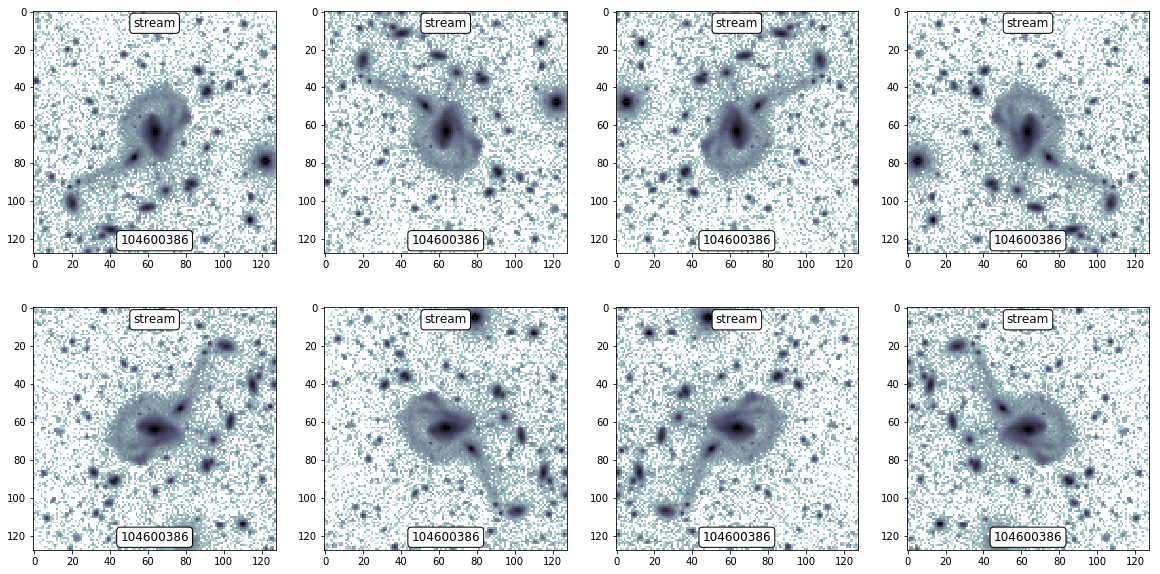

In [52]:
import matplotlib.pyplot as plt
import numpy as np

dataFile = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_i_Images-RAugNorm.npy'
catFile = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/Positive_i_Images-RAug_cat.npy'
inp = np.load(dataFile)
cat = np.load(catFile)
print(inp.shape)
print(cat.shape)
print(inp.dtype)
print(np.max(inp))
print(np.min(inp))
inp1d = inp.flatten()
print(len(inp1d))
print(len(inp1d[np.isnan(inp1d)]))

fig,axarr = plt.subplots(2,4,figsize=(20,10))
axarr = axarr.flatten()

# number between 0 and 1200
index = 500
nOrig = 1201

for i in range(8):
    objID = cat[index+(nOrig*i)][0]
    morphID = cat[index+(nOrig*i)][1]
    axarr[i].imshow(inp[index+(nOrig*i)][:,:,0],vmin=0,vmax=1,cmap='bone_r')
    axarr[i].text(0.5,0.025,'{}'.format(objID),transform=axarr[i].transAxes,ha='center',va='bottom',fontsize=12,
       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    axarr[i].text(0.5,0.975,'{}'.format(morphID),transform=axarr[i].transAxes,ha='center',va='top',fontsize=12,
       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))




## Applying model to new data

### Import modules

In [1]:
#!/usr/bin/env python

import os,sys,json
import keras
from keras import backend as K
from keras.models import Model,load_model
from keras.layers import Input,Dense,Dropout,Flatten
from keras.utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn import model_selection as md
from keras import regularizers
import numpy as np




Using TensorFlow backend.


### Define model

In [2]:
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        
######################################################################
def HSC_Subaru_CNN(args):
    
    dx,dy,nChannels = args
    
    # convolution model
    inputs = Input(shape=(dx,dy,nChannels), name='main_input')
    # first conv layer
    x = Conv2D(32, kernel_size=(5,5),activation='relu',
               padding='same',strides=(1, 1),name='Conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
    #x = Dropout(0.5,name='Drop_C1')(x)
    # second conv layer
    x = Conv2D(64, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
    #x = Dropout(0.25,name='Drop_C2')(x)
    # third conv layer
    x = Conv2D(128, kernel_size=(2,2),activation='relu',
               padding='same',strides=(1, 1),name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
    #x = Dropout(0.25,name='Drop_C3')(x)
    # fourth conv layer
    x = Conv2D(128, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_4')(x)
    # x = Dropout(0.25,name='Drop_C4')(x)
    # flatten for fully connected layers
    x = Flatten(name='Flatten')(x)

    # Fully Connected Layer
    x = Dense(64,activation='relu',name='Dense_1')(x)
    x = Dropout(0.5,name='DropFCL_1')(x)
    x = Dense(16,activation='relu',name='Dense_2')(x)
    x = Dropout(0.5,name='DropFCL_2')(x)
    x = Dense(1,activation='sigmoid',name='Dense_3')(x)

    # connect and compile
    model = Model(inputs=inputs,outputs=x)
    model.compile(optimizer=keras.optimizers.Adadelta(), 
                  loss='binary_crossentropy',metrics=['accuracy'])
    return model
######################################################################

### Load data

In [2]:
classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
fileNames = ['{}{}_i_Images-RAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

tar = np.array([])
inp = np.array([])
# Negatives
inp_neg = np.load(fileNames[0])[:10000]
print('Negatives:',inp_neg.shape)
# inp_neg = np.zeros(shape=(20010,128,128)) # !!! for testing
cat_neg = np.load(catNames[0])[:10000]
tar_neg = np.append(tar,np.ones(inp_neg.shape[0])*0)
# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
cat_pos = np.load(catNames[1])
tar_pos = np.ones(inp_pos.shape[0])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0)
cat = np.concatenate([cat_neg,cat_pos],axis=0)
tar = np.append(tar_neg,tar_pos)

Negatives: (10000, 128, 128, 1)
Positives: (9608, 128, 128, 1)


In [77]:
nRecords,dx,dy,nChannels = inp.shape
nClasses=len(classIDs)
#del new_inp,new_cat

batch_size = 32
epochs=100
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 1
label = 'HSC-Subaru'
          
randomStates = np.arange(10)

for randomState in randomStates[:1]:

    modelFile = modelDir+'{}_Binary_RS-{}_v{}_{}.h5'
    historyFile = modelDir+'{}_Binary_RS-{}_v{}_{}_history.json'
    if os.access(modelFile.format(label,randomState,version,update),0): continue

    modelFile = modelFile.format(label,randomState,version,update)
    print('Model will save as: {}'.format(modelFile))
    historyFile = historyFile.format(label,randomState,version,update)
    print('History will save as: {}'.format(historyFile))
    
    mcp_file = modelFile.replace('.h5','_wgts.hdf5')
    early_stopping = EarlyStopping(monitor='val_acc', patience=999, verbose=1, mode='max')
    mcp_save = ModelCheckpoint(mcp_file, save_best_only=True, monitor='val_acc', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid = md.train_test_split(inp, tar, cat, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test = md.train_test_split(inp_valid, tar_valid, cat_valid, test_size=valid_test_split, random_state=randomState)

    args = (dx,dy,nChannels)
    model = HSC_Subaru_CNN(args)
    
    model.summary()

    model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
              batch_size=batch_size,validation_data=[inp_valid,tar_valid],
              callbacks=[early_stopping, mcp_save]) 
    
    save_model_history(model=model,history_filename=historyFile)
    if os.access(mcp_file,0):
        model.load_weights(mcp_file)
        os.remove(mcp_file)
    model.save(modelFile)



Model will save as: /home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/HSC-Subaru_Binary_RS-0_v1_0.h5
History will save as: /home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/HSC-Subaru_Binary_RS-0_v1_0_history.json
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 128, 128, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 128, 128, 32)      832       
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 32, 32, 64)        0         
______________________________________________

KeyboardInterrupt: 

## Examine model long-term performance



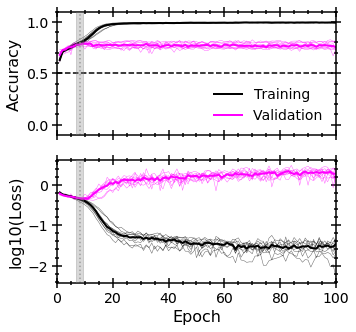

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from keras.models import load_model
from glob import glob


epochs=100
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 1
label = 'HSC-Subaru'

modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'

modelFiles = list(sorted(glob('{}{}_Binary_RS-*_v{}_{}.h5'.format(modelDir,label,version,update))))

historyFiles = list(sorted(glob('{}{}_Binary_RS-*_v{}_{}_history.json'.format(modelDir,label,version,update))))

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
fig,axarr = plt.subplots(2,1,figsize=(5,5),sharex=True)
fig.subplots_adjust(hspace=0.2)

for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True,right=True,size=10,width=1.5)
    ax.tick_params(axis='both',which='minor',direction='inout',size=4)

ax = axarr[1]
ax.set_xlabel(r'Epoch',fontsize=16)
ax.set_ylabel(r'log10(Loss)',fontsize=16)
ax.set_xlim(0,100)
ax = axarr[0]
ax.set_ylabel(r'Accuracy',fontsize=16)
ax.set_xlim(0,100)
ax.set_ylim(-0.1,1.1)

stats = np.empty(shape=(100,4,len(historyFiles)))

for i,fileName in enumerate(historyFiles):
    with open(fileName) as f:
        history = json.load(f)
    acc = history['acc']
    stats[:,0,i]=acc
    vacc = history['val_acc']
    stats[:,1,i]=vacc
    loss = history['loss']
    stats[:,2,i]=loss
    vloss = history['val_loss']
    stats[:,3,i]=vloss
    epochs = np.arange(len(acc))+1
    
    axarr[0].plot(epochs,acc,color='black',linestyle='solid',alpha=0.6,linewidth=0.5)
    axarr[0].plot(epochs,vacc,color='magenta',linestyle='solid',alpha=0.6,linewidth=0.5)
    
    axarr[1].plot(epochs,np.log10(loss),color='black',linestyle='solid',alpha=0.6,linewidth=0.5)
    axarr[1].plot(epochs,np.log10(vloss),color='magenta',linestyle='solid',alpha=0.6,linewidth=0.5)

med_acc = np.nanmedian(stats[:,0,:],axis=1)
med_vacc = np.nanmedian(stats[:,1,:],axis=1)
stopping = np.argmin(stats[:,3,:],axis=0)

med_loss = np.nanmedian(stats[:,2,:],axis=1)
med_vloss = np.nanmedian(stats[:,3,:],axis=1)
axarr[0].plot(epochs,med_acc,linewidth=2,c='black',label='Training')
axarr[0].plot(epochs,med_vacc,linewidth=2,c='magenta',label='Validation')
ax.legend(frameon=False,loc=4)

mean_stop = np.nanmean(stopping)
std_stop = np.nanstd(stopping)
for ax in axarr:
    
    ax.axvline(mean_stop,c='darkgrey',linestyle='dotted',linewidth=1.5)
    ax.axvspan(mean_stop-std_stop,mean_stop+std_stop, alpha=0.3, color='grey',zorder=9)
    
axarr[1].plot(epochs,np.log10(med_loss),linewidth=2,c='black')
axarr[1].plot(epochs,np.log10(med_vloss),linewidth=2,c='magenta')

axarr[0].axhline(y=0.5,linestyle='dashed',c='black')

fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_100epochs_acc-loss.pdf'.format(version,update),
            bbox_inches='tight')

## Histograms

Negatives: (10000, 128, 128, 1)
Positives: (9608, 128, 128, 1)


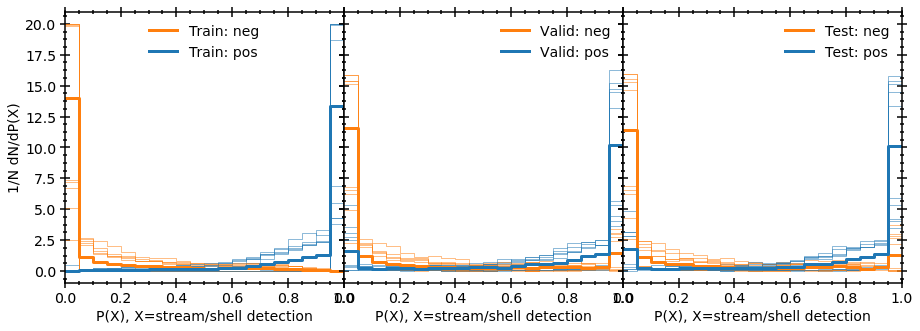

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from sklearn import model_selection as md
from keras.models import load_model
from glob import glob
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
from glob import glob

def splitData(inp,tar,cat,randomState,args):
    '''Split data for a given random state.'''
    train_valid_split, valid_test_split = args
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid = md.train_test_split(inp, tar, cat, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test = md.train_test_split(inp_valid, tar_valid, cat_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train, tar_train, cat_train, inp_valid, tar_valid, cat_valid, inp_test, tar_test, cat_test

def Hist_and_Plot(ax,xedges,out,tar,classID):
    if classID == 1: colour = 'C0'
    if classID == 0: colour = 'C1'
    H,xedges = np.histogram(out.flatten()[tar==classID],bins=xedges,density=False)
    H = H/widths/np.sum(H)
    ax.step(x=xedges,y=np.append(H,H[-1]),color=colour,where='post',linewidth=0.5)
    return H

def Plot_H(ax,H,xedges,args):
    colour,linewidth,linestyle,label = args
    median = np.nanmedian(H,axis=0)
    median = median/np.nansum(median)/widths
    ax.step(x=xedges,y=np.append(median,median[-1]),color=colour,where='post',
                  linewidth=linewidth,linestyle=linestyle,label=label)

classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
fileNames = ['{}{}_i_Images-RAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

tar = np.array([])
inp = np.array([])
# Negatives
inp_neg = np.load(fileNames[0])[:10000]
print('Negatives:',inp_neg.shape)
cat_neg = np.load(catNames[0])[:10000]
tar_neg = np.append(tar,np.ones(inp_neg.shape[0])*0)
# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
cat_pos = np.load(catNames[1])
tar_pos = np.ones(inp_pos.shape[0])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0)
cat = np.concatenate([cat_neg,cat_pos],axis=0)
tar = np.append(tar_neg,tar_pos)

epochs=100
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 1
label = 'HSC-Subaru'

# Histogram params
xmin,xmax=0.,1.
nbins = 20
xedges = np.linspace(xmin,xmax,nbins+1)
widths = (xedges[1:]-xedges[:-1])
xcs = xedges[:-1]+widths/2.

# figure initialization
fig,axarr = plt.subplots(1,3,figsize=(15,5),sharey=True)
fig.subplots_adjust(wspace=0.)
for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True,right=True,size=10,width=1.5)
    ax.tick_params(axis='both',which='minor',direction='inout',size=4)

randomStates = np.arange(10)

H_train_neg = np.empty(shape=(len(randomStates),nbins))
H_train_pos = np.empty(shape=(len(randomStates),nbins))
H_valid_neg = np.empty(shape=(len(randomStates),nbins))
H_valid_pos = np.empty(shape=(len(randomStates),nbins))
H_test_neg = np.empty(shape=(len(randomStates),nbins))
H_test_pos = np.empty(shape=(len(randomStates),nbins))

for ii,randomState in enumerate(randomStates):
    fileName = '{}{}_Binary_RS-{}_v{}_{}.h5'.format(modelDir,label,randomState,version,update)
    model = load_model(fileName)
    args = (train_valid_split,valid_test_split)
    inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test = splitData(inp,tar,cat,randomState,args)

    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))

    H_train_neg[ii] = Hist_and_Plot(axarr[0],xedges,out_train,tar_train,classID=0)
    H_valid_neg[ii] = Hist_and_Plot(axarr[1],xedges,out_valid,tar_valid,classID=0)
    H_test_neg[ii] = Hist_and_Plot(axarr[2],xedges,out_test,tar_test,classID=0)
    
    H_train_pos[ii] = Hist_and_Plot(axarr[0],xedges,out_train,tar_train,classID=1)
    H_valid_pos[ii] = Hist_and_Plot(axarr[1],xedges,out_valid,tar_valid,classID=1)
    H_test_pos[ii] = Hist_and_Plot(axarr[2],xedges,out_test,tar_test,classID=1)

args = ('C1',3,'solid','Train: neg')
Plot_H(axarr[0],H_train_neg,xedges,args)
args = ('C0',3,'solid','Train: pos')
Plot_H(axarr[0],H_train_pos,xedges,args)
axarr[0].legend(frameon=False)

args = ('C1',3,'solid','Valid: neg')
Plot_H(axarr[1],H_valid_neg,xedges,args)
args = ('C0',3,'solid','Valid: pos')
Plot_H(axarr[1],H_valid_pos,xedges,args)
axarr[1].legend(frameon=False)

args = ('C1',3,'solid','Test: neg')
Plot_H(axarr[2],H_test_neg,xedges,args)
args = ('C0',3,'solid','Test: pos')
Plot_H(axarr[2],H_test_pos,xedges,args)
axarr[2].legend(frameon=False)

axarr[0].set_ylabel(r'1/N dN/dP(X)')

for ax in axarr.flat:
    ax.set_xlim(xmin-0.05,xmax+0.05)
    ax.set_xlabel(r'P(X), X=stream/shell detection')
    
fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_100epochs_Px.pdf'.format(version,update),
            bbox_inches='tight')

In [39]:
fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_100epochs_Px.pdf'.format(version,update),
            bbox_inches='tight')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,json
from sklearn import model_selection as md
from keras.models import load_model
from glob import glob
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 14
from glob import glob

def splitData(inp,tar,cat,randomState,args):
    '''Split data for a given random state.'''
    train_valid_split, valid_test_split = args
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid = md.train_test_split(inp, tar, cat, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test = md.train_test_split(inp_valid, tar_valid, cat_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train, tar_train, cat_train, inp_valid, tar_valid, cat_valid, inp_test, tar_test, cat_test

classIDs = ['Negative','Positive']
dataDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Data/Binary/'
modelDir = '/home/bottrell/scratch/Subaru/HyperSuprime/Models/Binary/'
fileNames = ['{}{}_i_Images-RAugNorm.npy'.format(dataDir,classID) for classID in classIDs]
catNames = ['{}{}_i_Images-RAug_cat.npy'.format(dataDir,classID) for classID in classIDs]

tar = np.array([])
inp = np.array([])
# Negatives
inp_neg = np.load(fileNames[0])[:10000]
print('Negatives:',inp_neg.shape)
cat_neg = np.load(catNames[0])[:10000]
tar_neg = np.append(tar,np.ones(inp_neg.shape[0])*0)
# Positives
inp_pos = np.load(fileNames[1])
print('Positives:',inp_pos.shape)
cat_pos = np.load(catNames[1])
tar_pos = np.ones(inp_pos.shape[0])
# Combining
inp = np.concatenate([inp_neg,inp_pos],axis=0)
cat = np.concatenate([cat_neg,cat_pos],axis=0)
tar = np.append(tar_neg,tar_pos)

epochs=100
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 1
label = 'HSC-Subaru'

Negatives: (10000, 128, 128, 1)
Positives: (9608, 128, 128, 1)


0
1
2
3
4
5
6
7
8
9


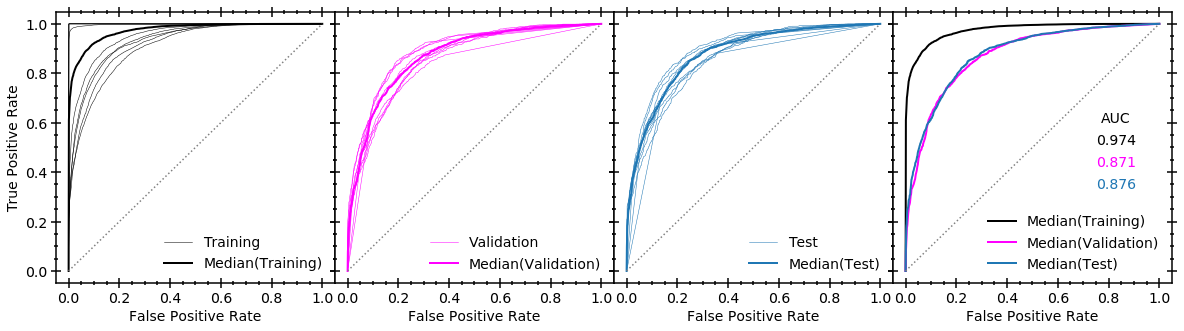

In [4]:
from sklearn import metrics

fig,axarr = plt.subplots(1,4,figsize=(20,5),sharey=True)
fig.subplots_adjust(wspace=0.)
for ax in axarr.flat:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True,right=True,size=10,width=1.5)
    ax.tick_params(axis='both',which='minor',direction='inout',size=4)
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)
axarr[0].set_ylabel('True Positive Rate')

randomStates = np.arange(10)

fpr_all = np.linspace(0,1,1001)
tpr_train = np.empty(shape=(len(randomStates),1001))
tpr_valid = np.empty(shape=(len(randomStates),1001))
tpr_test = np.empty(shape=(len(randomStates),1001))

for i,randomState in enumerate(randomStates):
    
    fileName = '{}{}_Binary_RS-{}_v{}_{}.h5'.format(modelDir,label,randomState,version,update)
    model = load_model(fileName)
    args = (train_valid_split,valid_test_split)
    inp_train,tar_train,cat_train,inp_valid,tar_valid,cat_valid,inp_test,tar_test,cat_test = splitData(inp,tar,cat,randomState,args)
    
    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))
    print(i)
    
    ax = axarr[0]
    fpr, tpr, thresholds = metrics.roc_curve(tar_train, out_train)
    auc = np.trapz(tpr,fpr)
    tpr = np.interp(fpr_all,fpr,tpr,left=0.,right=1)
    tpr[0]=0.
    tpr[-1]=1.
    tpr_train[i]=tpr
    ax.plot(fpr_all,tpr,color='black',linewidth=0.5,label=('Training' if randomState==randomStates[0] else None))

    ax = axarr[1]
    fpr, tpr, thresholds = metrics.roc_curve(tar_valid, out_valid)
    auc = np.trapz(tpr,fpr)
    tpr = np.interp(fpr_all,fpr,tpr,left=0.,right=1)
    tpr[0]=0.
    tpr[-1]=1.
    tpr_valid[i]=tpr
    ax.plot(fpr_all,tpr,color='magenta',linewidth=0.5,label=('Validation' if randomState==randomStates[0] else None))

    ax = axarr[2]
    fpr, tpr, thresholds = metrics.roc_curve(tar_test, out_test)
    auc = np.trapz(tpr,fpr)
    tpr = np.interp(fpr_all,fpr,tpr,left=0.,right=1)
    tpr[0]=0.
    tpr[-1]=1.
    tpr_test[i]=tpr
    ax.plot(fpr_all,tpr,color='C0',linewidth=0.5,label=('Test' if randomState==randomStates[0] else None))

tpr_train_med = np.nanmedian(tpr_train,axis=0)
tpr_valid_med = np.nanmedian(tpr_valid,axis=0)
tpr_test_med = np.nanmedian(tpr_test,axis=0)

axarr[3].text(0.8,0.58,r'AUC',transform=axarr[3].transAxes,va='bottom',ha='center',color='black')

axarr[0].plot(fpr_all,tpr_train_med,color='black',linewidth=2,label='Median(Training)')
auc = np.trapz(tpr_train_med,fpr_all)
axarr[3].text(0.8,0.5,r'{}'.format('%0.3f'%auc),transform=axarr[3].transAxes,va='bottom',ha='center',color='black' )

axarr[1].plot(fpr_all,tpr_valid_med,color='magenta',linewidth=2,label='Median(Validation)')
auc = np.trapz(tpr_valid_med,fpr_all)
axarr[3].text(0.8,0.42,r'{}'.format('%0.3f'%auc),transform=axarr[3].transAxes,va='bottom',ha='center',color='magenta' )

axarr[2].plot(fpr_all,tpr_test_med,color='C0',linewidth=2,label='Median(Test)')
auc = np.trapz(tpr_test_med,fpr_all)
axarr[3].text(0.8,0.34,r'{}'.format('%0.3f'%auc),transform=axarr[3].transAxes,va='bottom',ha='center',color='C0' )

axarr[3].plot(fpr_all,tpr_train_med,color='black',linewidth=2,label='Median(Training)')
axarr[3].plot(fpr_all,tpr_valid_med,color='magenta',linewidth=2,label='Median(Validation)')
axarr[3].plot(fpr_all,tpr_test_med,color='C0',linewidth=2,label='Median(Test)')

for ax in axarr.flat:
    ax.plot([-0.0,1.0],[-0.0,1.0],linestyle='dotted',c='grey')
    ax.set_xlabel('False Positive Rate')
    ax.legend(frameon=False,loc=4)

fig.savefig('/home/bottrell/scratch/Subaru/HyperSuprime/Figures/Binary_10models_v{}_{}_100epochs_ROC.pdf'.format(version,update),
            bbox_inches='tight')